<a href="https://colab.research.google.com/github/eking03/Data110-Fall2025/blob/main/Data110_Project1_EmmaKing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

I wanted to use a dataset from Data Montgomery because working with local government data has always been a valuable experience for me. In doing so, I learn a lot about services able locally and how the county operates.

In browsing the catalog, I came across datasets about pavement condition in 2019 and 2022, and snow emergency roads. Assuming these datasets overlapped, joining them together could reveal insights that would be impossible to discern from a single dataset alone.

Also, taking my broader objectives into consideration, I was interested in learning to merge data and work with spatial data in Python.


## Importing libraries

In [5]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install contextily

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as cx


## Setting up dataframes

In [7]:
snow = pd.read_csv('https://raw.githubusercontent.com/eking03/Data110-Fall2025/refs/heads/main/Data/Snow_Emergency_EO_Roads_20251025.csv')
pave19 = pd.read_csv('https://raw.githubusercontent.com/eking03/Data110-Fall2025/refs/heads/main/Data/Pavement_Condition_Index_2019_20251025.csv')
pave22 = pd.read_csv('https://raw.githubusercontent.com/eking03/Data110-Fall2025/refs/heads/main/Data/Pavement_Condition_Index_2022_20251025.csv')


In [8]:
snow = snow[['CENSUS_ID', 'CFCC', 'SPEED']]
snow = snow.rename(columns={'CENSUS_ID' : 'Segment_ID'})

pave19 = pave19[['Segment_ID', 'PCI', 'MOCO_MAINT', 'Length_1']]
pave22 = pave22[['Segment_ID', 'PCI', 'MOCO_MAINT']]

pave19 = pave19.rename(columns={'PCI' : 'PCI_19', 'MOCO_MAINT' : 'MOCO_MAINT_19'})
pave22 = pave22.rename(columns={'PCI' : 'PCI_22', 'MOCO_MAINT' : 'MOCO_MAINT_22'})

pave19['Length_1'] = pave19['Length_1'].str.replace(',', '').astype(float)

pave = pd.merge(pave22, pave19, on='Segment_ID')
pave['ChangePCI'] = pave['PCI_22'] - pave['PCI_19']

df = pd.merge(pave, snow, on='Segment_ID', how='left')
df['SNOW_RD'] = np.where(df['CFCC'].notnull(), 'Snow', 'Regular')

df['Segment_ID'] = df['Segment_ID'].str.replace(',', '')


In [9]:
road_data = [['Total roads indexed', len(pd.merge(pave22, pave19, on='Segment_ID', how='outer'))],
             ['Roads indexed in\nboth 2019 and 2022', len(pd.merge(pave22, pave19, on='Segment_ID', how='inner'))],
             ['Total snow emergency roads', len(snow)],
             ['Snow emergency roads with\nPCI score from 2019 and 2022', len(pd.merge(pave, snow, on='Segment_ID', how='inner'))]]

road_data = pd.DataFrame(road_data, columns=['road_data', 'n_roads'])

In [10]:
pci_gdf = gpd.read_file('https://raw.githubusercontent.com/eking03/Data110-Fall2025/master/Data/Pavement_Condition_Index_20251028.geojson')

pci_gdf = pci_gdf[['segment_id', 'geometry']]
pci_gdf = pci_gdf.rename(columns={'segment_id' : 'Segment_ID'})

pci_gdf = pd.merge(pci_gdf, df, on='Segment_ID', how='inner')

I exported all datasets as CSV files and, additionally, exported the 2019 dataset as a GeoJSON file.

I started this project with the assumption that the datasets had a common ancestor, that there would be a unique ID for each road, and that the road IDs would be consistent across the three datasets.

In both pavement condition datasets, there were three ID attributes: `CENSUS_ID`, `OBJECT_ID`, and `Segment_ID`. In the data from 2019, each ID column had a unique value for each entry and `CENSUS_ID` and `Segment_ID` were duplicates of each other. In the data from 2022, there were several instances of repeating values (non-unique IDs) in both `CENSUSID` and `OBJECT_ID`. I joined the 2019 and 2022 datasets by `Segment_ID`, only keeping roads that were indexed in both 2019 and 2022 -- a total of 24,152 observations.

There were 15 and 14 columns in the 2019 and 2022 datasets, respectively. I discarded most columns, but kept the pavement condition index (`PCI`) score, maintenance responsibility (`MOCO_MAINT`), and street length (`Length_1`), then renamed them to reflect their dataset of origin. In the Snow Emergency Roads dataset, there were 2,645 observations with 17 attributes. 2,098 of those observations were also indexed in the PCI datasets.

Even after thorough research, I was unable to locate a data dictionary for the datasets. This meant that I was unable to utilize certain columns, like surface type.


## Exploratory Data Analysis

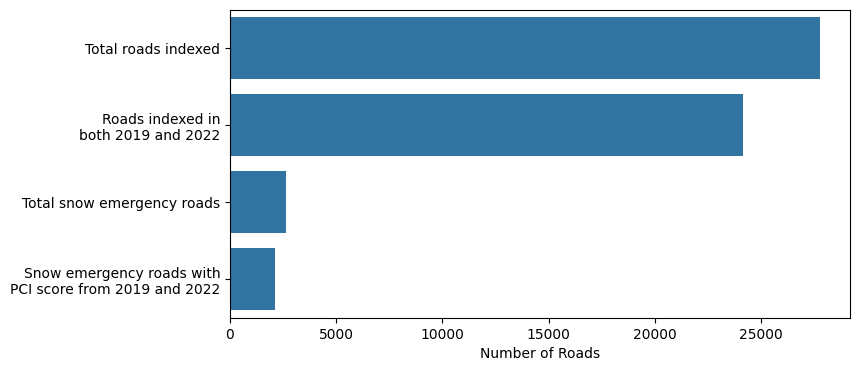

In [11]:
plt.figure(figsize=(8,4))

sns.barplot(data=road_data, y='road_data', x='n_roads')
plt.xlabel('Number of Roads')
plt.ylabel('')
plt.show()

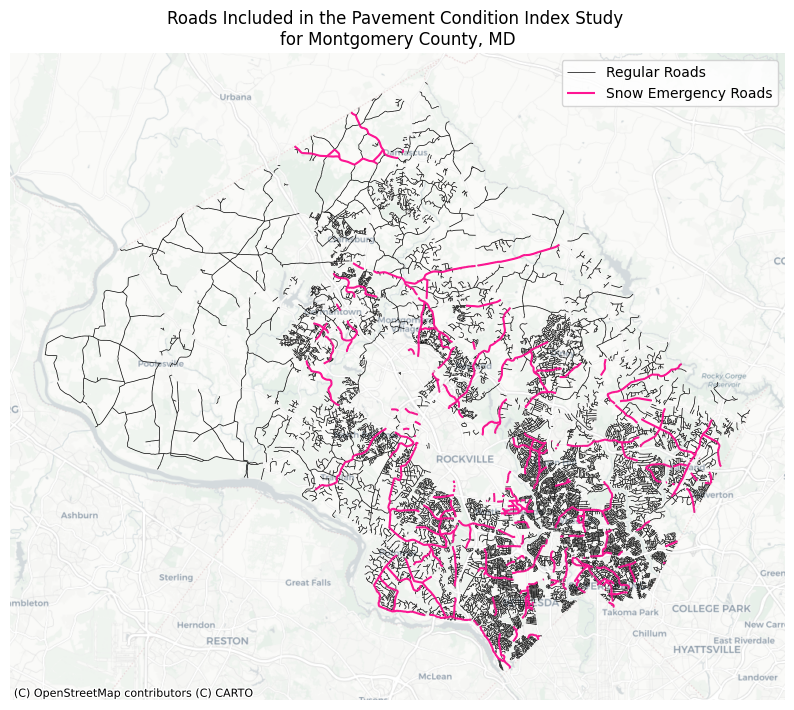

In [12]:
fig, ax = plt.subplots(1, figsize = (10,10))

pci_gdf.to_crs('EPSG:3857').plot(ax=ax, color='black', linewidth = 0.5, label='Regular Roads')
pci_gdf[pci_gdf['SNOW_RD'] == 'Snow'].to_crs('EPSG:3857').plot(ax=ax, color='deeppink', label='Snow Emergency Roads')

cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.Positron)
plt.title('Roads Included in the Pavement Condition Index Study \nfor Montgomery County, MD')
plt.axis('off')
plt.legend()
plt.show()

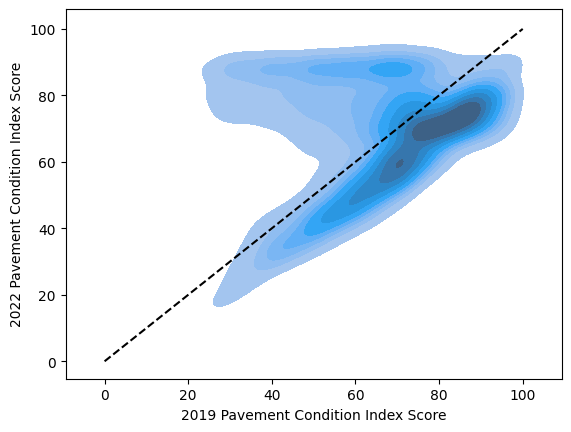

In [13]:
x = np.linspace(0, 100, 1000)
sns.lineplot(x=x, y=x, color='black', linestyle='dashed')

sns.kdeplot(data=df, x='PCI_19', y='PCI_22', fill=True)
plt.xlabel('2019 Pavement Condition Index Score')
plt.ylabel('2022 Pavement Condition Index Score')
plt.show()

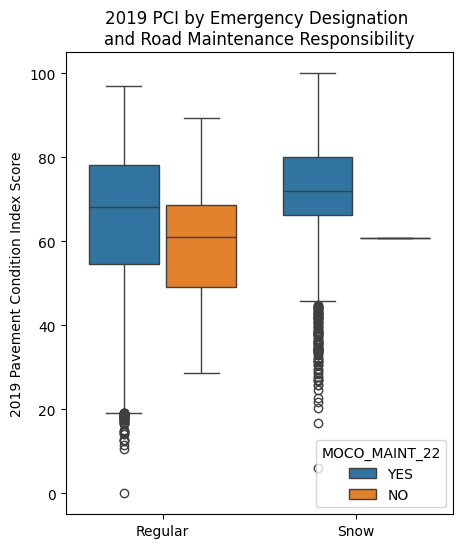

In [14]:
my_color = sns.color_palette(["#1f77b4", "#ff7f0e"])
plt.figure(figsize=(5,6))

sns.boxplot(data=df, x='SNOW_RD', y='PCI_19', hue='MOCO_MAINT_22', gap=0.1, palette=my_color)
plt.xlabel('')
plt.ylabel('2019 Pavement Condition Index Score')
plt.title('2019 PCI by Emergency Designation \nand Road Maintenance Responsibility')
plt.show()

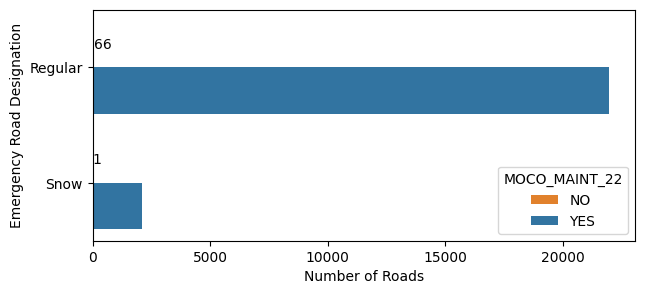

In [28]:
boxbar = df.groupby(['MOCO_MAINT_22', 'SNOW_RD']).count().reset_index()
boxbar = boxbar[['MOCO_MAINT_22', 'SNOW_RD', 'Segment_ID']]
boxbar = boxbar.rename(columns={'Segment_ID' : 'N_ROWS'})

my_color = sns.color_palette(["#ff7f0e", "#1f77b4"])
plt.figure(figsize=(7,3))

ax = sns.barplot(data=boxbar, x='N_ROWS', y='SNOW_RD', hue='MOCO_MAINT_22', palette=my_color)
ax.bar_label(ax.containers[0])
# ax.bar_label(ax.containers[1])
plt.xlabel('Number of Roads')
plt.ylabel('Emergency Road Designation')
plt.show()

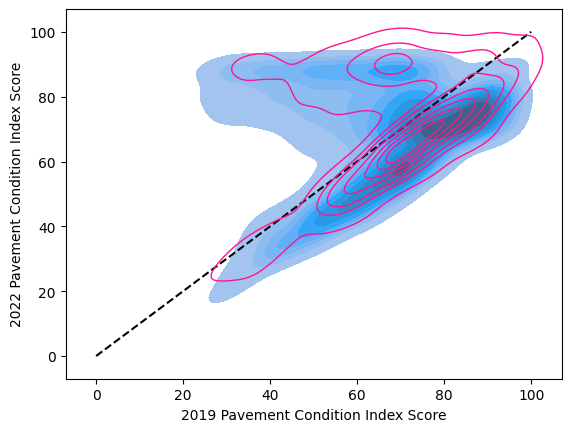

In [17]:
x = np.linspace(0, 100, 1000)
sns.lineplot(x=x, y=x, color='black', linestyle='dashed')

sns.kdeplot(data=df[df['SNOW_RD'] != 'Snow'], x='PCI_19', y='PCI_22', fill=True)
sns.kdeplot(data=df[df['SNOW_RD'] == 'Snow'], x='PCI_19', y='PCI_22', color='deeppink', levels=8, linewidths=1)

plt.xlabel('2019 Pavement Condition Index Score')
plt.ylabel('2022 Pavement Condition Index Score')
plt.xlim(-7,107)
plt.ylim(-7,107)
plt.show()

This graph compares the distribution of pavement condition index scores in 2019 to scores in 2022. The dashed line represents no change in score. The densest region of the plot is around 2019 scores of 70 to 90 and 2022 scores of 60 to 80. This result shows that, in 2019, most roads were very good condition, but, by 2022, their condition had slightly deteriorated. The densest region being just under the dashed line shows that their score declined. This likely reflects that since the roads were in good condition, they received no intervention. There is another dense region above the dashed line, 2019 scores of 60 to 80 and 2022 scores of 80 to 90. In documents published by the county council on the priorities for road management, it stated that one of their initiatives was to apply preventative maintenance to roads in good condition, instead of waiting for them to become completely dilapidated since that would require more expensive repairs. The 2022 scores of roads in fair to poor condition in 2019, with scores from 30 to 50, diverged. Some roads slightly declined, like most roads did without intervention, while others experienced a large improvement in score. These results suggest that roads that were in poor condition were fully renovated.


This graph compares the distribution of pavement condition index scores from 2019 and 2022 for roads that are not designated as snow emergency roads. The distributions are the same as what was observed for all roads. Superimposed on the blue filled 2d density plot is a pink contour plot which represents the score distribution for snow emergency roads. The pink contour lines were chosen over a filled density plot because the two plots overlap the same area and the contour lines allow the density plot underneath to be visible.

The pink plot shows that snow emergency roads have higher scores overall, but especially in 2022. There are also less snow emergency roads in poor condition. Otherwise, the pink plot shows the concentration of scores in the same places: slight declines for most roads, large improvement for some roads in poor construction, and preventative maintenance.


The interquartile range of 2019 PCI scores for Montgomery County maintained snow roads is more narrow than that of regular roads, Montgomery County maintained or otherwise. Among regular roads, the roads maintained by Montgomery County are, on average, in better condition than those that are not. In assessing this graph, it’s important to consider that there is a large discrepancy between the number of roads represented by each box plot category. Of the non-emergency roads that were scored, over 20,000 were maintained by Montgomery County, while only 66 are maintained by other entities. Of the snow emergency roads, there is only one road that is not maintained by Montgomery County.


## Appendix

*The following graphs in this section were included in the presentation, but were not necessary for the report.*

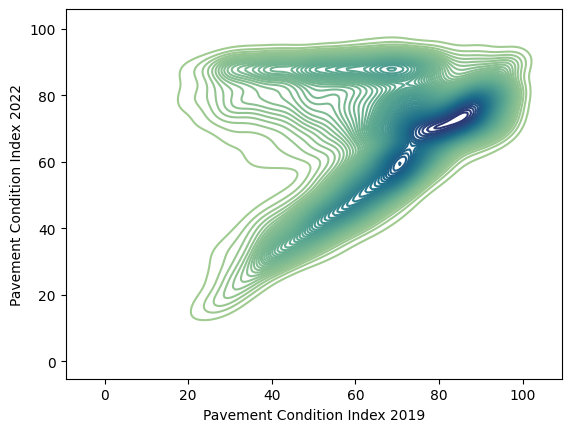

In [18]:
sns.kdeplot(x=df['PCI_19'], y=df['PCI_22'], fill=False, cmap='crest', thresh=0, levels=60)
plt.xlabel('Pavement Condition Index 2019')
plt.ylabel('Pavement Condition Index 2022')
plt.show()

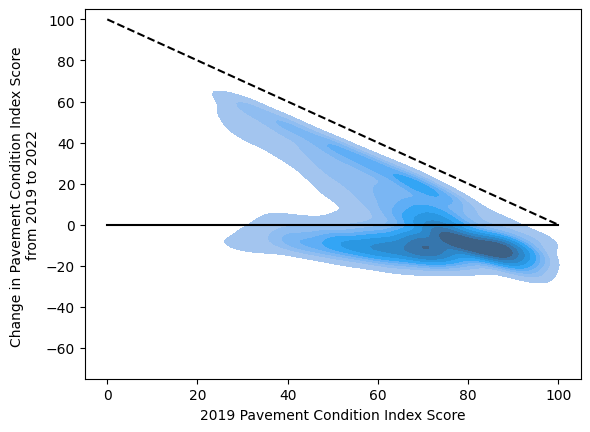

In [23]:
x = np.linspace(0, 100, 1000)

sns.lineplot(x=x, y=100-x, color='black', linestyle='dashed')
sns.lineplot(x=x, y=0*x, color='black', linestyle='solid')
sns.kdeplot(data=df, x='PCI_19', y='ChangePCI', fill=True)
plt.xlabel('2019 Pavement Condition Index Score')
plt.ylabel('Change in Pavement Condition Index Score \nfrom 2019 to 2022')
plt.xlim(-5,105)
plt.ylim(-75,105)
plt.show()

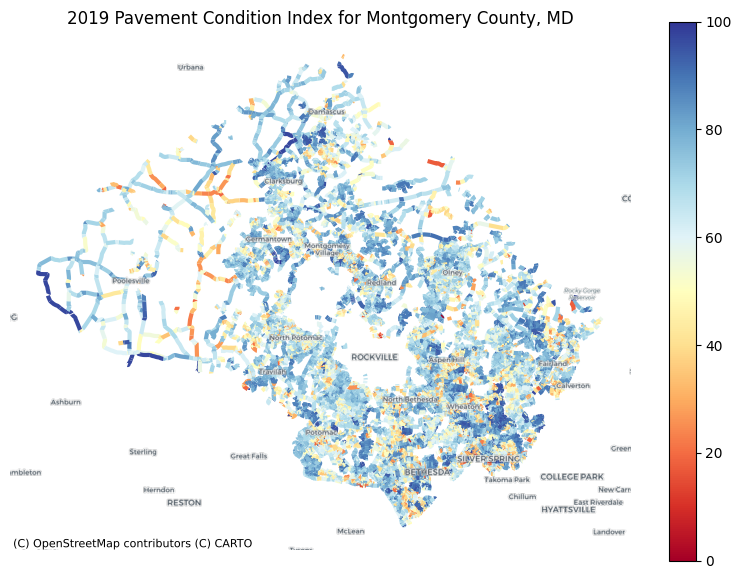

In [20]:
fig, ax = plt.subplots(1, figsize = (10,7))

pci_gdf.to_crs('EPSG:3857').plot(ax=ax, column='PCI_19', cmap='RdYlBu', linewidth=3, legend=True)
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.PositronOnlyLabels)
plt.title('2019 Pavement Condition Index for Montgomery County, MD')
plt.axis('off')
plt.show()

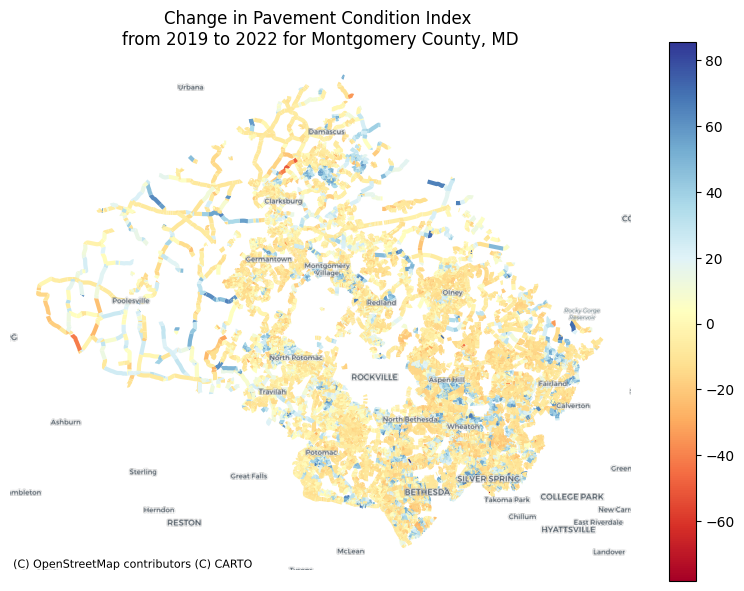

In [21]:
fig, ax = plt.subplots(1, figsize = (10,7))

pci_gdf.to_crs('EPSG:3857').plot(ax=ax, column='ChangePCI', cmap='RdYlBu', legend=True, linewidth=3)
cx.add_basemap(ax=ax,  source=cx.providers.CartoDB.PositronOnlyLabels)
plt.title('Change in Pavement Condition Index \nfrom 2019 to 2022 for Montgomery County, MD')
plt.axis('off')
plt.show()

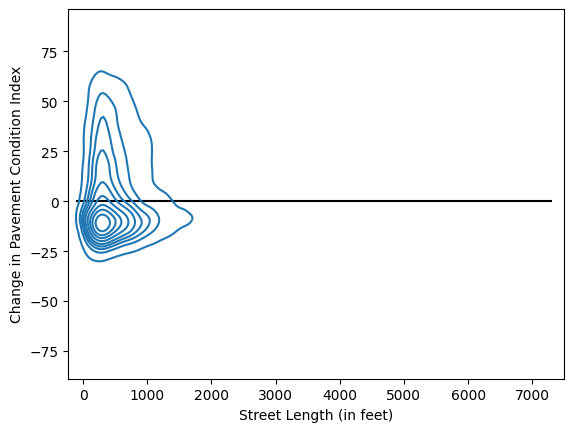

In [22]:
x = np.linspace(-100, 7300, 1000)
sns.lineplot(x=x, y=0*x, color='black', linestyle='solid')

sns.kdeplot(data=df, x='Length_1', y='ChangePCI')
plt.xlabel('Street Length (in feet)')
plt.ylabel('Change in Pavement Condition Index')
plt.show()